In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
from pathlib import Path
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import PIL
import torch.nn.functional as F
from PIL import Image
from typing import Tuple
from tqdm import tqdm
import pickle
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

warnings.filterwarnings("ignore")
train_on_gpu = torch.cuda.is_available()
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson', 12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/')
train_val_files_path = sorted(list(train_dir.rglob('*.jpg')))
test_path = sorted(list(test_dir.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files_path]
train_files_path, val_files_path = train_test_split(train_val_files_path, test_size = 0.3, stratify=train_val_labels)
num_classes = len(np.unique(train_val_labels))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class ConvolutionNetwork(nn.Module):
    def __init__(self, img_size: Tuple[int, int] = (3, 224, 224), num_classes: int = num_classes):
        super().__init__()
        in_channels = img_size[0]
        height = img_size[1]
        width = img_size[2]
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same')
        self.btch = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.btch = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same')
        self.btch = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 64)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [3]:
class SimpsonsDataset(Dataset):
    def __init__(self, files_path, data_transforms):
        super().__init__()
        self.files_path = files_path
        self.transform = data_transforms
        if 'test' not in str(self.files_path[0]):
            self.labels = [path.parent.name for path in self.files_path]
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, idx):
        img_path = str(self.files_path[idx])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        if 'test' in str(self.files_path[0]):
            return image
        else:
            label_str = str(self.files_path[idx].parent.name)
            label = self.label_encoder.transform([label_str]).item()
            return image, label

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionNetwork()
model = model.to(device)
input_size = 224
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

In [5]:
train_dataset = SimpsonsDataset(train_files_path, transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor()]))
val_dataset = SimpsonsDataset(val_files_path, transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor()]))
test_dataset = SimpsonsDataset(test_path, transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor()]))
sample = test_dataset[0]

In [14]:
dataloader_train_dataset = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
dataloader_val_dataset = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)
dataloader_test_dataset = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

In [7]:
import sklearn

def get_accuracy(model, data_loader, device):
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
    return sklearn.metrics.f1_score(predicted, labels)

def get_f1_score(model, data_loader, device):
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return sklearn.metrics.f1_score(true_labels, predicted_labels, average='weighted')

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
    start = time.time()
    for epoch in range(epochs):
        startep = time.time()
        accs = []
        for i, (images, labels) in enumerate(data_loader):
            labels = labels.to(device)
            images = images.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = loss_function(outputs, labels)
            acc = accuracy(outputs, labels)
            accs.append(acc)
            loss.backward()
            optimizer.step()
            endep = time.time()
        print('Epoch {}: acc = {}, time = {}'.format(epoch + 1, torch.stack(accs).mean(), endep - startep))
    end = time.time()
    print('Total time {}'.format(end - start))

In [8]:
train(model, dataloader_train_dataset, 100, criterion, optimizer, device)

Epoch 1: acc = 0.06276784092187881, time = 79.4641432762146
Epoch 2: acc = 0.09388865530490875, time = 54.188974380493164
Epoch 3: acc = 0.10190162062644958, time = 54.23198199272156
Epoch 4: acc = 0.10880367457866669, time = 53.59248113632202
Epoch 5: acc = 0.12244798988103867, time = 55.75993633270264
Epoch 6: acc = 0.14781105518341064, time = 56.07185888290405
Epoch 7: acc = 0.17652352154254913, time = 57.210198640823364
Epoch 8: acc = 0.22088158130645752, time = 56.6973614692688
Epoch 9: acc = 0.24518553912639618, time = 55.366485595703125
Epoch 10: acc = 0.2672537565231323, time = 56.12690234184265
Epoch 11: acc = 0.28258585929870605, time = 55.96978712081909
Epoch 12: acc = 0.29463815689086914, time = 55.66333341598511
Epoch 13: acc = 0.3100627064704895, time = 55.1285617351532
Epoch 14: acc = 0.32350656390190125, time = 55.68712854385376
Epoch 15: acc = 0.33414167165756226, time = 55.27556753158569
Epoch 16: acc = 0.35104742646217346, time = 54.60121703147888
Epoch 17: acc = 0.3

In [15]:
print('Acc = {}'.format(get_f1_score(model, dataloader_val_dataset, device)))

Acc = 0.9084368502009454


In [20]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    plt_ax.grid(False)
    
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

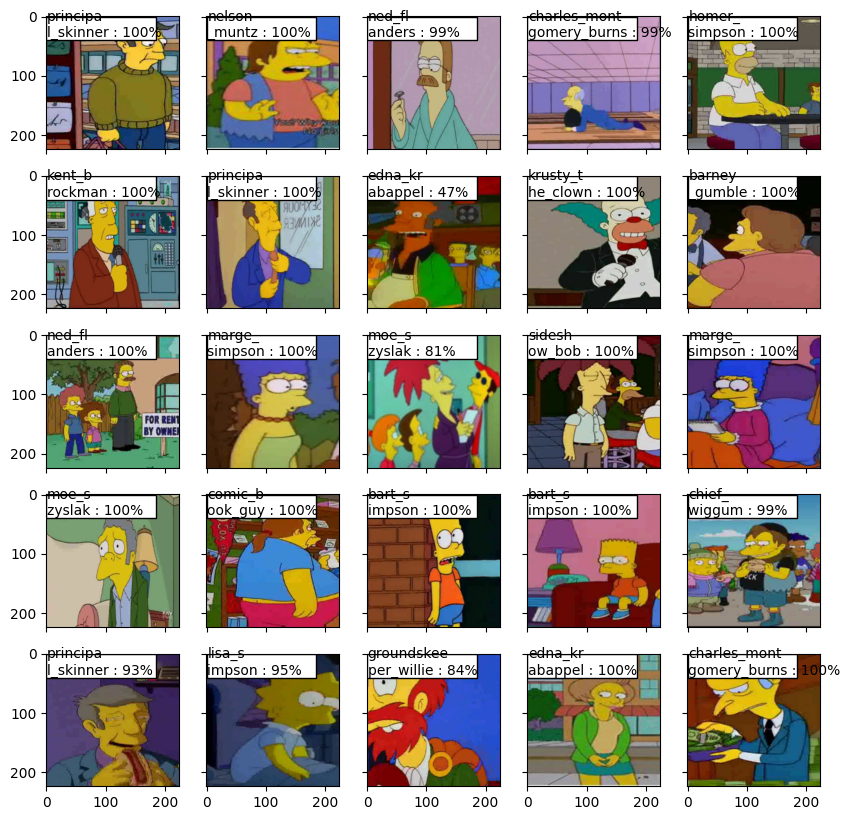

In [24]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10),  sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
    fig_x.add_patch(patches.Rectangle((0, 0), 185, 40,edgecolor = 'black',linewidth=1, facecolor='white'))
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)       
    fig_x.text(1, 35, predicted_text)